In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    import random
    random.seed(seed)

set_seed(42)

# Load the dataset and preprocess the dataset

In [12]:

train_data = pd.read_csv('./Google_Stock_Price_Train.csv')
test_data = pd.read_csv('./Google_Stock_Price_Test.csv')


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [14]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


Overall:Because the data of the training set and the test set have certain format problems and the data of the validation set is too small, these problems will be dealt with next, and the training set and the test set will be merged and redistributed into training set, test set and validation set.

In [15]:
def preprocess_data(data):
    if 'Volume' in data.columns:
        data['Volume'] = data['Volume'].replace(',', '', regex=True)
    if 'Close' in data.columns:
        data['Close'] = data['Close'].replace(',', '', regex=True)
    data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
    data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data.fillna(data.mean(), inplace=True)
    return data

In [16]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

In [17]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = pd.concat([train_data[features], test_data[features]])

In [18]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [19]:
# Time series data construction
N = 30
X, y = [], []
for i in range(N, len(scaled_data)):
    X.append(scaled_data[i - N:i])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)


In [ ]:
# split the data set
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# Build GRU model

In [ ]:
def build_gru_model():
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        GRU(128),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    return model

# learning rate
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
# early stop
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model

In [ ]:

set_seed(42)
model = build_gru_model()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)


Epoch 1/50


c:\Users\Aufb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1522 - val_loss: 0.3075 - learning_rate: 1.0000e-04
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0523 - val_loss: 0.0870 - learning_rate: 1.0000e-04
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0117 - val_loss: 0.0114 - learning_rate: 1.0000e-04
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0056 - val_loss: 0.0046 - learning_rate: 1.0000e-04
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0046 - val_loss: 0.0080 - learning_rate: 1.0000e-04
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0034 - val_loss: 0.0074 - learning_rate: 1.0000e-04
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0032 - val_loss: 0.0046 - learning_rate: 1.0000e-04
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0032 - val_loss: 0.0037 - learning_rate: 1.0000e-04
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025 - val_loss: 0.0030 - learning_rate: 1.000

# Test the model

In [ ]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:

def inverse_transform_predictions(pred, y, scaler, features):
    pred_original = scaler.inverse_transform(
        np.hstack([pred, np.zeros((pred.shape[0], len(features) - 1))])
    )[:, 0]

    y_original = scaler.inverse_transform(
        np.hstack([y.reshape(-1, 1), np.zeros((y.shape[0], len(features) - 1))])
    )[:, 0]
    return pred_original, y_original

train_pred_original, y_train_original = inverse_transform_predictions(train_pred, y_train, scaler, features)
val_pred_original, y_val_original = inverse_transform_predictions(val_pred, y_val, scaler, features)
test_pred_original, y_test_original = inverse_transform_predictions(test_pred, y_test, scaler, features)

In [ ]:

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    accuracy = 100 - (rmse / np.mean(y_true)) * 100
    return mse, rmse, mae, accuracy

train_mse, train_rmse, train_mae, train_acc = evaluate_model(y_train_original, train_pred_original)
val_mse, val_rmse, val_mae, val_acc = evaluate_model(y_val_original, val_pred_original)
test_mse, test_rmse, test_mae, test_acc = evaluate_model(y_test_original, test_pred_original)

print(f"Train MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, Accuracy: {train_acc:.2f}%")
print(f"Validation MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}, Accuracy: {val_acc:.2f}%")
print(f"Test MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, Accuracy: {test_acc:.2f}%")


Train MSE: 156.7919, RMSE: 12.5217, MAE: 8.8994, Accuracy: 97.30%
Validation MSE: 359.5790, RMSE: 18.9626, MAE: 14.7582, Accuracy: 97.29%
Test MSE: 189.8099, RMSE: 13.7772, MAE: 11.2129, Accuracy: 98.19%


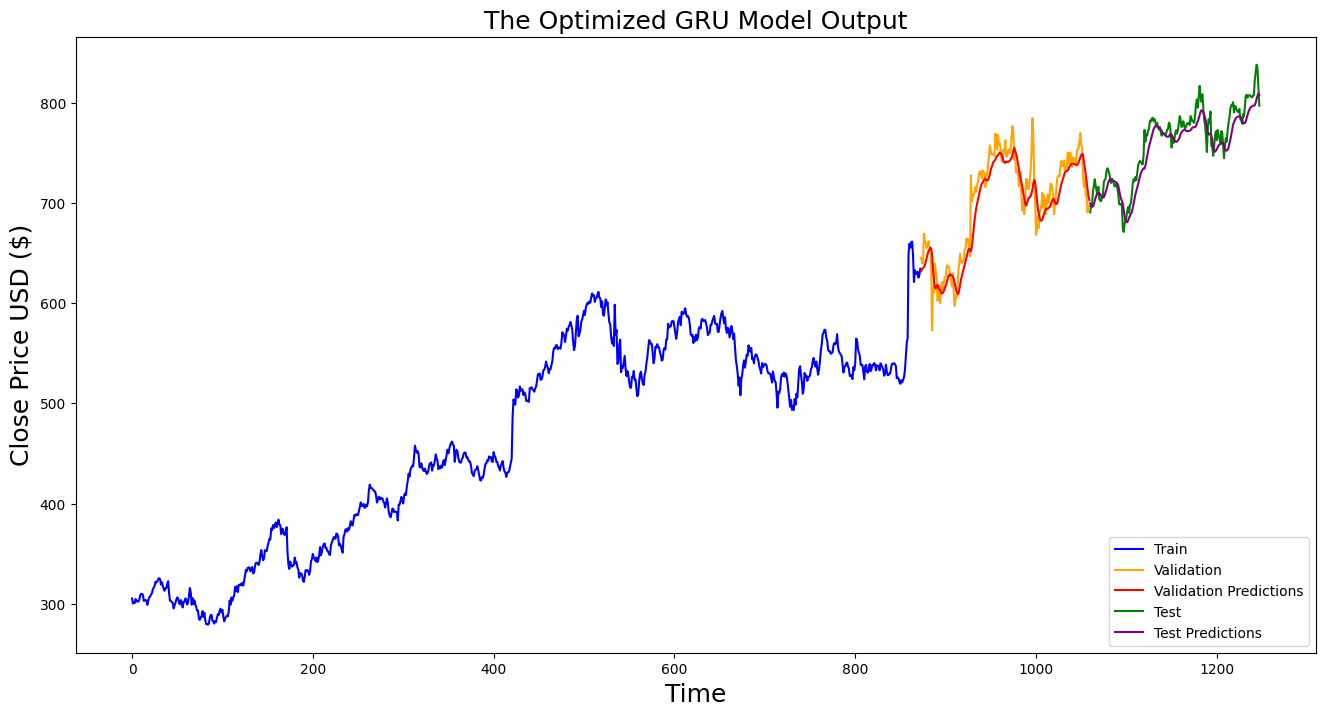

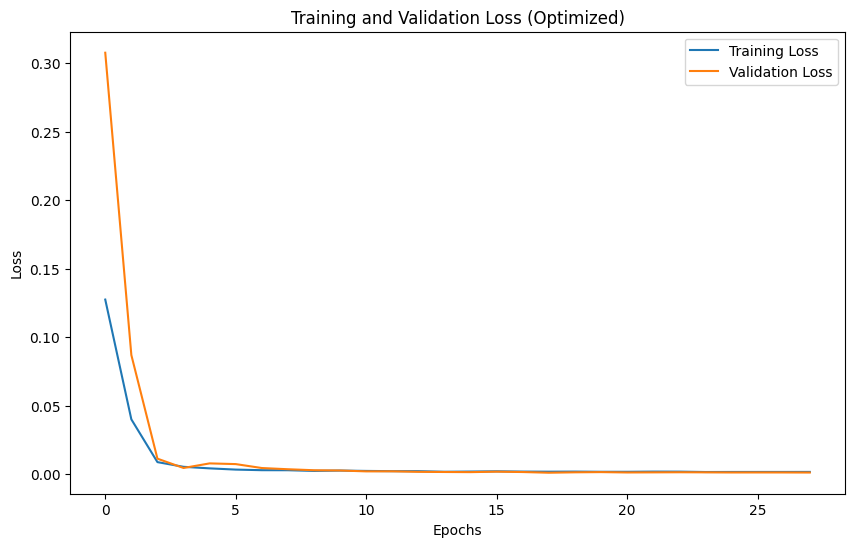

In [ ]:

plt.figure(figsize=(16, 8))
plt.title('The Optimized GRU Model Output', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(y_train_original, label='Train', color='blue')
plt.plot(range(len(y_train_original), len(y_train_original) + len(y_val_original)), y_val_original, label='Validation', color='orange')
plt.plot(range(len(y_train_original), len(y_train_original) + len(y_val_original)), val_pred_original, label='Validation Predictions', color='red')
plt.plot(range(len(y_train_original) + len(y_val_original), len(y_train_original) + len(y_val_original) + len(y_test_original)), y_test_original, label='Test', color='green')
plt.plot(range(len(y_train_original) + len(y_val_original), len(y_train_original) + len(y_val_original) + len(y_test_original)), test_pred_original, label='Test Predictions', color='purple')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Optimized)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
